***
In this notebook, we will show how to create glacier maps to represent glacial extent and properties for a SPHY model input.
***

# 00. Load Packages

In [17]:
# TODO review and edit
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import os
import pcraster as pcr
import pcr_tool

import pandas as pd
import cartopy
from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import mapping
import rasterio
from rasterio.features import rasterize


# 01. Basic Setup for a Bhutan watershed (Punatsangchhu, Wangchhu, Amochhu, and Jaldakah)

In [2]:
epsg_model = 5266 # Bhutan National Grid: a transverse Mercator projection
epsg_lonlat = 4326 # the common lat-lon coordinate reference system

path_data = os.path.join('..', 'data')
path_output = os.path.join('..', 'input') # the "input" folder will be directly used as an input path for the SPHY model run
os.makedirs(path_output, exist_ok = True)

# plotting options
flag_plot_aguila = True
flag_plot_cartopy = True

# Bhutan Administrative Boundaries (Level 1) to be added in a plot
path_shape = os.path.join(path_data, 'SHAPE', 'btn_admbnda_adm1_bnlc_20201026.shp')
shape_geometry = cartopy.io.shapereader.Reader(path_shape).geometries()
shape_feature = cartopy.feature.ShapelyFeature(shape_geometry, crs = cartopy.crs.PlateCarree(), facecolor = 'none', linewidth = 0.25)

# 02. Load Clonemap and DEM

First, we need to declare the class that we will be using throughout this notebook, with an EPSG to define a clonemap.

In [3]:
print(f'- Input EPSG:\n{epsg_model}')
map_clone = pcr_tool.clonemap(epsg = epsg_model)

- Input EPSG:
5266


In [4]:
# load clonemap
path_clonemap = os.path.join(path_output, 'clone.map')
print(f'- Input PCRaster Path for Clonemap:\n{path_clonemap}')
map_clone.load_clonemap(path = path_clonemap)

# load DEM
path_dem = os.path.join(path_output, 'dem.map')
print(f'- Input PCRaster Path for DEM:\n{path_dem}')
map_dem = map_clone.read_pcraster(path = path_dem)
map_clone.set_dem(map_dem)

print('- Outputs:')
print(map_dem)

# plots
if flag_plot_aguila:
    pcr.aguila(map_clone.clonemap)
    pcr.aguila(map_dem)

- Input PCRaster Path for Clonemap:
../input/clone.map
- Input PCRaster Path for DEM:
../input/dem.map
- Outputs:


# 03. Load Glacier Data

Read in glacier dataset. Here we are using ICIMOD's Hindu-Kush Himalaya glacier dataset which provides glacier extent from 2005 ± 3 years
https://doi.org/10.26066/RDS.31029

In [5]:
# load glacier dataset
path_glacier = os.path.join(path_data, 'GLACIER', 'HKH_CIDC_5basins_all.shp')
gpd_glacier = gpd.read_file(path_glacier)

# convert coordinate system to Bhutan CRS
gpd_glacier_md = gpd_glacier.to_crs(epsg_model)

# 04. Create Domain Bounding Box and Clip Glacier Data

In [6]:
# convert dem to xarray
da_dem = map_clone.to_xarray(
    field = path_dem, # pcraster.Field to convert into xarray.DataArray
    varname = 'dem', # variable name in xarray.DataArray
    )
ds_dem = da_dem.to_dataset(name = 'elev_media')

# create bounding box to clip glacier data
x_min = da_dem.x.min().values
x_max = da_dem.x.max().values
y_min = da_dem.y.min().values
y_max = da_dem.y.max().values

poly_bb = box(x_min, y_min, x_max, y_max)

gdf_bb = gpd.GeoDataFrame([1], geometry=[poly_bb], crs=epsg_model)

In [7]:
# clip glacier data
gpd_glacier_clip = gpd_glacier_md.clip(gdf_bb)

<Axes: >

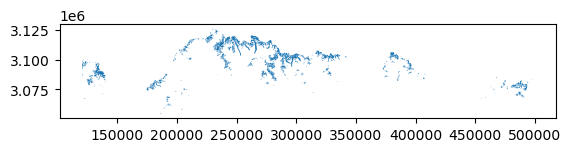

In [8]:
# plot clipped data
gpd_glacier_clip.plot()

# 

# 05. Create Glacier Table

In [9]:
# create polygons for each grid cell

y_vec = da_dem['y'].values # extract y dimension data from Xarray
x_vec = da_dem['x'].values # extract x dimension data from Xarray

x_inc = x_vec[1] - x_vec[0] # assumes uniform increment
y_inc = y_vec[1] - y_vec[0] # assumes uniform increment

polygons = []
for i in range(len(y_vec)):
    for j in range(len(x_vec)):
        polygon = Polygon([(x_vec[j] - x_inc / 2, y_vec[i] + y_inc / 2),
                           (x_vec[j] + x_inc / 2, y_vec[i] + y_inc / 2),
                           (x_vec[j] + x_inc / 2, y_vec[i] - y_inc / 2),
                           (x_vec[j] - x_inc / 2, y_vec[i] - y_inc / 2)])
        polygons.append(polygon)

gpd_grid = gpd.GeoDataFrame(geometry = polygons, crs = epsg_model)

for var_name in ds_dem.data_vars:
    gpd_grid[var_name] = ds_dem[var_name].values.flatten()

# compute grid cell areas
gpd_grid['area'] = gpd_grid['geometry'].area

# create unique ID for each grid cell
gpd_grid['MOD_ID'] = range(1, len(gpd_grid) + 1)

In [10]:
# create unique list of glaciers from glacier ID and condition (debris-covered and clean-ice; in `Glaciers` attribute)
glac_list = gpd_glacier_clip[['GLIMS_ID', 'Glaciers']].drop_duplicates().reset_index(drop=True)

# create unique glacier ID
glac_list['GLAC_ID'] = 1000 + glac_list.index + 1

In [11]:
# build glacier table
glac_tbl = pd.DataFrame()

# iterate over each row in glac_list
for i, row in glac_list.iterrows():
    id_sel = row['GLIMS_ID']
    cond_sel = row['Glaciers']
    glacid_sel = row['GLAC_ID']

    # select individual glaciers
    glac_sf_sel = gpd_glacier_clip[(gpd_glacier_clip['GLIMS_ID'] == id_sel) &
                                    (gpd_glacier_clip['Glaciers'] == cond_sel)]

    # calculate the intersection and area
    glac_tbl_temp = gpd.overlay(gpd_grid, glac_sf_sel, how='intersection')
    glac_tbl_temp['area_glac'] = glac_tbl_temp.area
    glac_tbl_temp['FRAC_GLACIER'] = glac_tbl_temp['area_glac'] / glac_tbl_temp['area']

    # rename columns to match SPHY format
    glac_tbl_temp = glac_tbl_temp.drop(columns='geometry')
    glac_tbl_temp = glac_tbl_temp.rename(columns={'elev_media': 'MOD_H', 'Thickness': 'ICE_DEPTH'})
    glac_tbl_temp['DEBRIS'] = 0 if cond_sel == 'Clean Ice' else 1
    glac_tbl_temp['GLAC_H'] = glac_tbl_temp['MOD_H'] + glac_tbl_temp['ICE_DEPTH']
    glac_tbl_temp['GLAC_ID'] = glacid_sel
    glac_tbl_temp = glac_tbl_temp[['MOD_ID', 'GLAC_ID', 'MOD_H', 'GLAC_H', 'DEBRIS', 'FRAC_GLACIER', 'ICE_DEPTH']]

    # append temporary dataframe to glacier table
    glac_tbl = pd.concat([glac_tbl, glac_tbl_temp], ignore_index=True)

# arrange table
glac_tbl_fmt = glac_tbl.sort_values(by=['MOD_ID', 'GLAC_ID'])

# create unique ID for each glacier-grid cell intersection
glac_tbl_fmt['U_ID'] = range(1, len(glac_tbl_fmt) + 1)

# select columns needed by SPHY
glac_tbl_fmt = glac_tbl_fmt[['U_ID', 'MOD_ID', 'GLAC_ID', 'MOD_H', 'GLAC_H', 'DEBRIS', 'FRAC_GLACIER', 'ICE_DEPTH']]


In [12]:
# U_ID: unique ID; combination of MOD_ID and GLAC_ID
# MOD_ID: nominal map with a unique ID for each model grid cell
# GLAC_ID: nominal map with a unique ID for each glacier
# MOD_H: model cell DEM elevation
# GLAC_H: glacier elevation
# DEBRIS (0/1): flag indicating whether debris-covered
# FRAC_GLACIER: fraction of grid cell as glacier
# ICE_DEPTH: nominal glacier thickness; difference between model cell DEM  elevation and glacier elevation

# show glacier table
glac_tbl_fmt

,U_ID,MOD_ID,GLAC_ID,MOD_H,GLAC_H,DEBRIS,FRAC_GLACIER,ICE_DEPTH
0,1,41487,1001,5361.0,5378.06,0,0.122546,17.06
1,2,41487,1002,5361.0,5382.51,0,0.094789,21.51
2,3,41867,1002,4929.0,4950.51,0,0.105596,21.51
3,4,42644,1003,4455.0,4476.21,0,0.006057,21.21
4,5,42645,1003,4443.0,4464.21,0,0.002680,21.21
...,...,...,...,...,...,...,...,...
3975,3994,68134,1981,5678.0,5735.10,0,0.315617,57.10
3993,3995,68134,1989,5678.0,5705.38,0,0.007113,27.38
3996,3996,68510,1990,5765.0,5794.84,0,0.182546,29.84
3997,3997,68511,1990,5943.0,5972.84,0,0.213343,29.84


In [17]:
# save glacier table to csv
glac_tbl_fmt.to_csv('../input/GlacTable_bhutan_py.csv', index=False)


In [14]:
# create t lapse table
tlapse_df = pd.DataFrame({
    'month': range(1, 13),
    'fact': [0.005] * 12
})

tlapse_df.to_csv('../input/TLapse_Bhutan.csv', header = False, index = False)

# create glacier id map file


In [18]:
# create grid cell id map file

# Determine the bounding box of the GeoDataFrame
minx, miny, maxx, maxy = gpd_grid.total_bounds

# Define the resolution (cell size) for the raster
resolution = 1000  # Example resolution in units of the CRS

# Calculate the number of rows and columns in the raster
width = (maxx - minx) / resolution
height = (maxy - miny) / resolution

# Define the affine transform for the raster
transform = rasterio.transform.from_origin(minx, maxy, resolution, resolution)

# Function to determine value for rasterization (MOD_ID in this case)
def make_raster_value(row):
    return row.MOD_ID  # We use 'MOD_ID' column

# Create (burn) raster
burned_raster = rasterize(
    [(mapping(geom), make_raster_value(row)) for geom, row in zip(gpd_grid.geometry, gpd_grid.itertuples())],
    out_shape=(int(height), int(width)),
    transform=transform,
    fill=0,  # Fill value outside of polygons
    dtype=rasterio.int32  # Ensure the dtype fits the MOD_IDs
)

tiff_filename = '../input/ModelID.tif'
with rasterio.open(
    tiff_filename,
    'w',
    driver='GTiff',
    height=burned_raster.shape[0],
    width=burned_raster.shape[1],
    count=1,  # Single band
    dtype=burned_raster.dtype,
    crs=gpd_grid.crs.to_string(),  # Use CRS from the GeoDataFrame
    transform=transform
) as dst:
    dst.write(burned_raster, indexes=1)

# Convert the tiff to pcraster format
pcraster_filename = '../input/ModelID.map'
tiff_arr = rasterio.open(tiff_filename).read(1)
rows, cols = tiff_arr.shape
pcr.setclone(rows, cols, resolution, minx, maxy)  # This sets the spatial reference for PCRaster
pcr_arr = pcr.numpy2pcr(pcr.Scalar, tiff_arr.astype(np.float32), 0)  # Convert numpy array to PCRaster
pcr.report(pcr_arr, pcraster_filename)  # Save array to a .map file


In [29]:
# create glacier id map file

# use the bounding box of the grid cell ids
minx, miny, maxx, maxy = gpd_grid.total_bounds

# Define the resolution (cell size) for the raster
resolution = 100  # Example resolution in units of the CRS

# Calculate the number of rows and columns in the raster
width = (maxx - minx) / resolution
height = (maxy - miny) / resolution

# Define the affine transform for the raster
transform = rasterio.transform.from_origin(minx, maxy, resolution, resolution)

# Function to determine value for rasterization (MOD_ID in this case)
def make_raster_value(row):
    return row.ID  # We use 'ID' column

# Create (burn) raster
burned_raster = rasterize(
    [(mapping(geom), make_raster_value(row)) for geom, row in zip(gpd_glacier_clip.geometry, gpd_glacier_clip.itertuples())],
    out_shape=(int(height), int(width)),
    transform=transform,
    fill=0,  # Fill value outside of polygons
    dtype=rasterio.int32  # Ensure the dtype fits the MOD_IDs
)

tiff_filename = '../input/GlacID.tif'
with rasterio.open(
    tiff_filename,
    'w',
    driver='GTiff',
    height=burned_raster.shape[0],
    width=burned_raster.shape[1],
    count=1,  # Single band
    dtype=burned_raster.dtype,
    crs=gpd_glacier_clip.crs.to_string(),
    transform=transform
) as dst:
    dst.write(burned_raster, indexes=1)

# Convert the tiff to pcraster format
pcraster_filename = '../input/GlacID.map'
tiff_arr = rasterio.open(tiff_filename).read(1)
rows, cols = tiff_arr.shape
pcr.setclone(rows, cols, resolution, minx, maxy)  # This sets the spatial reference for PCRaster
pcr_arr = pcr.numpy2pcr(pcr.Scalar, tiff_arr.astype(np.float32), 0)  # Convert numpy array to PCRaster
pcr.report(pcr_arr, pcraster_filename)  # Save array to a .map file